### Сделать классификацию данных fakenews

Используя ноутбук занятия (также размещен в папке Materials) и данные fakenews, 3 раза разными способами получить на задаче классификации значение f1 выше 0.91 для методов на sklearn и выше 0.52 для методов на pytorch.

### 1. Проведите препроцессинг текста. Разбейте данные на train и test для задачи классификации.

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('Constraint_Train.csv')
df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [5]:
from sklearn.preprocessing import LabelEncoder
 
labelencoder = LabelEncoder()
 
df.loc[:, 'label'] = labelencoder.fit_transform(df.loc[:, 'label'])
df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,0


In [7]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksurashanti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
sentences = [word_tokenize(text.lower()) for text in tqdm(df.tweet)] #токенизируем текст, один твит - одно предложение


100%|██████████| 6420/6420 [00:01<00:00, 6092.00it/s]


In [13]:
from gensim.models.word2vec import Word2Vec
%time model_tweets = Word2Vec(sentences, workers=2, min_count=3, vector_size=300, window=5) #создаём векторные модели текста
#data — данные,
#size — размер вектора,
#window — размер окна наблюдения,
#min_count — мин. частотность слова в корпусе, которое мы берем,
#sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram)

CPU times: total: 1.55 s
Wall time: 873 ms


In [15]:
model_tweets.wv.most_similar('car')

[('khan', 0.9878685474395752),
 ('philippines', 0.987735390663147),
 ('antiviral', 0.9867477416992188),
 ('bank', 0.986312985420227),
 ('passed', 0.9861970543861389),
 ('party', 0.9856885671615601),
 ('cancer', 0.985531747341156),
 ('every', 0.9853814840316772),
 ('janeiro', 0.98531574010849),
 ('section', 0.9852690100669861)]

In [17]:
model_tweets.init_sims()

C:\Users\ksurashanti\AppData\Local\Temp\ipykernel_15172\2721725782.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_tweets.init_sims()


### 2. Векторизуйте

In [20]:
import numpy as np

In [22]:
def get_text_embedding(text):
    result = []
    for word in word_tokenize(text.lower()):
        if word in model_tweets.wv:
            result.append(model_tweets.wv[word])

    if len(result):
        result = np.sum(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [24]:
features = [get_text_embedding(text) for text in tqdm(df.tweet)]

100%|██████████| 6420/6420 [00:01<00:00, 4290.11it/s]


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, df.label, test_size=0.33)

### 3. Обучите на полученных векторах алгоритм классификации. Sklearn

Тестово попробовала линейную регрессию, результат 0.91.

##### LinearRegression
f1=0.91

In [36]:
from sklearn import linear_model

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [40]:
from sklearn.metrics import classification_report

In [42]:
predicted = model.predict(X_test)

In [44]:
predicted

array([ 0.92079538,  0.00641311,  0.57291039, ..., -0.15085752,
        0.30927998,  0.96691875])

In [46]:
pred_bi = []  #я совсем ку-ку и не нашла как пороги ставить через параметры моделей и вот руками написала.....
#если оставить в виде задачи регрессии, а не бинарной классификации, то f-метрика не работает 
for i in predicted:
    if i > 0.5:
        pred_bi.append(1)
    else:
        pred_bi.append(0)
print(len(pred_bi))

2119


In [48]:
pred_bi[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [50]:
y_test_list = y_test.tolist() #привожу к одному типу данных полученные и реальные предсказания

In [52]:
y_test_list[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [56]:
print(classification_report(y_test_list, pred_bi))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1006
           1       0.93      0.89      0.91      1113

    accuracy                           0.91      2119
   macro avg       0.91      0.91      0.91      2119
weighted avg       0.91      0.91      0.91      2119



##### BayesianRidge
f1 = 0.91

In [79]:
model = linear_model.BayesianRidge()
model.fit(X_train, y_train)

BayesianRidge()

In [81]:
predicted = model.predict(X_test)

In [83]:
predicted

array([ 0.89216784,  0.05270262,  0.55513314, ..., -0.10406407,
        0.26935803,  1.03348682])

In [85]:
pred_bi = []  
for i in predicted:
    if i > 0.5:
        pred_bi.append(1)
    else:
        pred_bi.append(0)
print(len(pred_bi))

2119


In [87]:
pred_bi[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [89]:
y_test_list[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [91]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test_list, pred_bi)
f1

0.9122486288848263

In [93]:
print(classification_report(y_test_list, pred_bi))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1006
           1       0.93      0.90      0.91      1113

    accuracy                           0.91      2119
   macro avg       0.91      0.91      0.91      2119
weighted avg       0.91      0.91      0.91      2119



##### ARDRegression

In [118]:
model = linear_model.ARDRegression()
model.fit(X_train, y_train)

ARDRegression()

In [119]:
predicted = model.predict(X_test)

In [120]:
predicted

array([ 0.88221286,  0.01775427,  0.58070119, ..., -0.13381516,
        0.26052522,  1.0319705 ])

In [121]:
pred_bi = [] 
for i in predicted:
    if i > 0.5:
        pred_bi.append(1)
    else:
        pred_bi.append(0)
print(len(pred_bi))

2119


In [122]:
pred_bi[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [126]:
y_test_list[0:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [130]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test_list, pred_bi)
f1

0.9142595139844109

In [132]:
print(classification_report(y_test_list, pred_bi))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1006
           1       0.93      0.90      0.91      1113

    accuracy                           0.91      2119
   macro avg       0.91      0.91      0.91      2119
weighted avg       0.91      0.91      0.91      2119



#### Вывод: 

В моделях LinearRegression, BayesianRidge и ARDRegression получился одинаковый f1-score - 0.91

### 4. Обучите на полученных векторах алгоритм классификации. Pytorch

##### LSTM

LSTM из вебинара получилось поднять только до 0,47 даже с 1000 итераций.

In [30]:
df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,0


In [32]:
labels = df.label.to_list() #pytorch не умеет работать с текстовыми данными, поэтому label обязательно переводить в числа. но я это уже
#и для sklearn сделала

In [34]:
token_lists = [word_tokenize(text.lower()) for text in df.tweet] #токенизируем тексты
max_len = len(max(token_lists, key=len))

In [36]:
max_len #максимальная длина твита, но можно посмотреть сколько в среднем в твите слов

1592

In [38]:
from collections import Counter
fd = Counter([len(tokens) for tokens in token_lists])

In [40]:
fd.most_common(10) #считаем, из скольки слов преимущественно состоит один твит, и это 20,25,22 слова

[(20, 178),
 (25, 174),
 (22, 170),
 (18, 170),
 (19, 168),
 (21, 168),
 (16, 163),
 (17, 162),
 (15, 160),
 (23, 156)]

In [42]:
def get_word_embedding(tokens, max_len): #как максимум берём 200
    result = []
    for i in range(max_len):
        if i < len(tokens):
            word = tokens[i]
            if word in model_tweets.wv:
                result.append(model_tweets.wv[word])
            else:
                result.append(np.zeros(300)) #должна быть одинаковая размерность матрицы, поэтому дозаполняем нулями
        else:
            result.append(np.zeros(300))
    return result

In [44]:
features = [get_word_embedding(text, 100) for text in tqdm(token_lists)] #создаём список из векторов каждого слова в тексте

100%|██████████| 6420/6420 [00:00<00:00, 6999.68it/s]


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

In [48]:
class Net(nn.Module): #используем нс lstm

    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(300, 100) #скрытый слой - 100
        self.out = nn.Linear(100, 1)

    def forward(self, x):
        embeddings, (shortterm, longterm) = self.lstm(x.transpose(0, 1))
        prediction = torch.sigmoid(self.out(longterm))
        return prediction


net = Net()
print(net)

Net(
  (lstm): LSTM(300, 100)
  (out): Linear(in_features=100, out_features=1, bias=True)
)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

In [52]:
in_data = torch.tensor(X_train).float() #переводим во float т.к модели пайторч чаще всего работают с таким типом данных
targets = torch.tensor(y_train).float()

C:\Users\ksurashanti\AppData\Local\Temp\ipykernel_15172\275355555.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  in_data = torch.tensor(X_train).float() #переводим во float т.к модели пайторч чаще всего работают с таким типом данных


In [53]:
in_data.shape

torch.Size([4494, 100, 300])

In [54]:
optimizer = optim.Adam(net.parameters(), lr=0.01) #задаём оптимизатор
criterion = nn.BCEWithLogitsLoss() #задаём функцию потерь

In [55]:
def train_one_epoch(in_data, targets, batch_size=16): #получает на вход данные которые обработали и метки, также размер батча
    for i in tqdm(range(0, in_data.shape[0], batch_size)): #в цикле проходимся с шагом = размеру батча и выбираем из данных тот кусочек, который подадим модели
        batch_x = in_data[i:i + batch_size].cpu() #поменяла на cpu
        batch_y = targets[i:i + batch_size].cpu()
        optimizer.zero_grad() #зануляем градиент
        output = net(batch_x) #прогоняем данные через нс
        loss = criterion(output.reshape(-1), batch_y) # считаем лосс функцию
        loss.backward() #получаем градиент для всех тензоров
        optimizer.step() #обновляем параметры модели, т.е делаем шаг оптимизации
    print(loss)

In [56]:
for i in range(1000):
  train_one_epoch(in_data, targets)

100%|██████████| 281/281 [00:03<00:00, 85.99it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 106.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.97it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 102.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 99.11it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.26it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.24it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 70.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.57it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 69.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 69.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 68.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 70.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 62.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 70.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 70.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 69.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 63.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 65.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 68.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 68.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.73it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 99.18it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.24it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 103.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.68it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.91it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.70it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.51it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.24it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 59.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.03it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 98.98it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 99.68it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.50it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 104.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 105.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 101.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.11it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.45it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 103.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.42it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 101.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 99.76it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.73it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.90it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.85it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.65it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.96it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 58.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 53.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 60.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 65.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:06<00:00, 44.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 36.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 38.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 35.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 37.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 48.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 35.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:06<00:00, 45.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 50.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 52.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:06<00:00, 46.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 60.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 53.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 67.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 70.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 61.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 58.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 47.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 31.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 46.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 72.83it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:05<00:00, 51.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:06<00:00, 41.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 39.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 39.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 23.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:10<00:00, 25.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 40.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:10<00:00, 26.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 23.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 23.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 20.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:20<00:00, 13.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 21.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 16.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:18<00:00, 15.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 30.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 28.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 22.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 16.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:32<00:00,  8.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 32.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 28.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 23.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 16.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 16.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 16.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 15.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 15.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 20.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 35.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 31.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 37.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 34.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 38.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 33.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 34.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 35.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:07<00:00, 38.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 30.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 24.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 28.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 28.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 17.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 20.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:19<00:00, 14.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:18<00:00, 15.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 18.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:22<00:00, 12.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 17.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 28.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 22.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:18<00:00, 15.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 25.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:23<00:00, 12.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 18.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 22.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 23.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:18<00:00, 15.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 25.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 25.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 25.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 15.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 20.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:32<00:00,  8.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:33<00:00,  8.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 22.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:10<00:00, 25.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:23<00:00, 11.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:22<00:00, 12.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:20<00:00, 13.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:23<00:00, 12.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:27<00:00, 10.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:28<00:00,  9.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:25<00:00, 11.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:23<00:00, 12.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 18.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 24.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 21.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:29<00:00,  9.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:20<00:00, 13.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:15<00:00, 18.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:22<00:00, 12.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 17.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:13<00:00, 20.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:12<00:00, 22.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:21<00:00, 13.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:21<00:00, 13.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:22<00:00, 12.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:25<00:00, 11.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:19<00:00, 14.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:08<00:00, 34.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 30.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 29.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:21<00:00, 12.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:24<00:00, 11.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:22<00:00, 12.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:10<00:00, 26.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:20<00:00, 14.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:20<00:00, 13.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:25<00:00, 11.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:21<00:00, 13.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:28<00:00,  9.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:16<00:00, 16.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:17<00:00, 15.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:14<00:00, 19.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:11<00:00, 23.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:10<00:00, 26.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:09<00:00, 30.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 60.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.96it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.28it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.07it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.52it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.80it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.96it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.28it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.78it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.28it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.96it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 97.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.56it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.27it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.44it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.56it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.57it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 96.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.63it/s] 


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 71.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.56it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 70.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.03it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.28it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.78it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.97it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.96it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.57it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.57it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.47it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.66it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 95.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.74it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.56it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.64it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.78it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.33it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.87it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.72it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.63it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.11it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.18it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.98it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 69.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.87it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.31it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.27it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 75.99it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.94it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.45it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.52it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.87it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.60it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.69it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.35it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.44it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.27it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.90it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.12it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.16it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.27it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.43it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.06it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.08it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 73.61it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.83it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.41it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.04it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.14it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.55it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.00it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.15it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.96it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.29it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.76it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.25it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.19it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.28it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.34it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 80.78it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.70it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.48it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.93it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.30it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.56it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.44it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.02it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.54it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.07it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.20it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.68it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.57it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.39it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.58it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.01it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.82it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.51it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.81it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.73it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.92it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 76.86it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.84it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.26it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 78.59it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.67it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.40it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.49it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.65it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 82.37it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.46it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 93.38it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 85.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 81.42it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.91it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.77it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 94.10it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 87.62it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 79.75it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:02<00:00, 93.85it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.36it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.95it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.21it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.17it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 86.88it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 84.22it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 88.32it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:04<00:00, 68.53it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.80it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 77.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.89it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 83.13it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 72.23it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.71it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 92.24it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.09it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 91.87it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 74.05it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.79it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 89.50it/s]


tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 281/281 [00:03<00:00, 90.96it/s]

tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Проверяем результат:

In [74]:
in_data_test = torch.tensor(X_test).float()
targets_test = torch.tensor(y_test).float()

In [75]:
with torch.no_grad(): 
    output = net(in_data_test.cpu()).reshape(-1)

In [76]:
max(torch.nn.functional.softmax(output))

C:\Users\ksurashanti\AppData\Local\Temp\ipykernel_15172\3603612712.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  max(torch.nn.functional.softmax(output))


tensor(0.0005)

In [77]:
targets_test

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [78]:
result = (output.cpu() > 0.5) == targets_test

In [79]:
result.sum().item() / len(result)

0.4636552440290758

##### Linear
c функцией потерь SoftMarginLoss и оптимизатором RMSprop

In [436]:
features = [get_text_embedding(text) for text in tqdm(df.tweet)]

100%|██████████| 6420/6420 [00:01<00:00, 4308.43it/s]


In [588]:
class Net(nn.Module):

    def __init__(self):
        out_features = 16
        super(Net, self).__init__()
        self.out = nn.Linear(300, 1)

    def forward(self, x):
        return torch.sigmoid(self.out(x))


net = Net()
print(net)

Net(
  (out): Linear(in_features=300, out_features=1, bias=True)
)


In [590]:
optimizer = optim.RMSprop(net.parameters(), lr=0.01)
criterion = nn.SoftMarginLoss()

In [592]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

In [594]:
in_data = torch.tensor(X_train).float()
targets = torch.tensor(y_train).float()

In [596]:
def train_one_epoch(in_data, targets, batch_size=16):
    for i in tqdm(range(0, in_data.shape[0], batch_size)):
        batch_x = in_data[i:i + batch_size].cpu()
        batch_y = targets[i:i + batch_size].cpu()
        optimizer.zero_grad()
        output = net(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(loss)

In [598]:
for i in range(50):
  train_one_epoch(in_data, targets)

100%|██████████| 301/301 [00:00<00:00, 1890.57it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1932.70it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1913.34it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1941.82it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1974.99it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1977.47it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1967.81it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1963.09it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1987.16it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2000.01it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1959.51it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2000.02it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1994.77it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2024.48it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1996.02it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2010.39it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1986.93it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2129.84it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2039.12it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2133.60it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1932.96it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1925.22it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2005.79it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1955.11it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1918.18it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1953.12it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2072.03it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1929.73it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2012.08it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1975.48it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2039.13it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2029.52it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2069.97it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 1963.29it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2051.76it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2069.37it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2013.29it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2051.06it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2074.19it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2079.55it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2073.17it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2084.23it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2069.64it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2059.95it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2066.50it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2059.67it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2020.56it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2032.61it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2048.93it/s]


tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:00<00:00, 2045.01it/s]

tensor(0.4905, grad_fn=<SoftMarginLossBackward0>)


In [324]:
in_data_test = torch.tensor(X_test).float()
targets_test = torch.tensor(y_test).float()

In [325]:
with torch.no_grad():
    output = net(in_data_test.cpu()).squeeze(1)

In [326]:
result = (output.cpu() > 0.5) == targets_test

In [327]:
result.sum().item() / len(result)

0.5227414330218069

Попробую добавить ещё слои lstm, linear, relu в нейросетку:

In [717]:
token_lists = [word_tokenize(text.lower()) for text in df.tweet] #токенизируем тексты
max_len = len(max(token_lists, key=len))

In [718]:
max_len

1592

In [719]:
def get_word_embedding(tokens, max_len): #как максимум берём 200
    result = []
    for i in range(max_len):
        if i < len(tokens):
            word = tokens[i]
            if word in model_tweets.wv:
                result.append(model_tweets.wv[word])
            else:
                result.append(np.zeros(300)) #должна быть одинаковая размерность матрицы, поэтому дозаполняем нулями
        else:
            result.append(np.zeros(300))
    return result

In [723]:
features = [get_word_embedding(text, 100) for text in tqdm(token_lists)] 

100%|██████████| 6420/6420 [00:00<00:00, 6910.02it/s]


In [725]:
class Net(nn.Module): #используем нс lstm

    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(300, 100) #скрытый слой - 100
        self.linear1 = nn.Linear(100,75)
        self.relu1 = nn.ReLU()
        self.out = nn.Linear(100, 1)

    def forward(self, x):
        embeddings, (shortterm, longterm) = self.lstm(x.transpose(0, 1))
        prediction = torch.sigmoid(self.out(longterm))
        return prediction


net = Net()
print(net)

Net(
  (lstm): LSTM(300, 100)
  (linear1): Linear(in_features=100, out_features=75, bias=True)
  (relu1): ReLU()
  (out): Linear(in_features=100, out_features=1, bias=True)
)


In [727]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

In [729]:
in_data = torch.tensor(X_train).float() #переводим во float т.к модели пайторч чаще всего работают с таким типом данных
targets = torch.tensor(y_train).float()

In [730]:
in_data.shape

torch.Size([4815, 100, 300])

In [731]:
optimizer = optim.RMSprop(net.parameters(), lr=0.01)
criterion = nn.SoftMarginLoss()

In [732]:
def train_one_epoch(in_data, targets, batch_size=16): #получает на вход данные которые обработали и метки, также размер батча
    for i in tqdm(range(0, in_data.shape[0], batch_size)): #в цикле проходимся с шагом = размеру батча и выбираем из данных тот кусочек, который подадим модели
        batch_x = in_data[i:i + batch_size].cpu() #поменяла на cpu
        batch_y = targets[i:i + batch_size].cpu()
        optimizer.zero_grad() #зануляем градиент
        output = net(batch_x) #прогоняем данные через нс
        loss = criterion(output.reshape(-1), batch_y) # считаем лосс функцию
        loss.backward() #получаем градиент для всех тензоров
        optimizer.step() #обновляем параметры модели, т.е делаем шаг оптимизации
    print(loss)

In [733]:
for i in range(2):
  train_one_epoch(in_data, targets)

100%|██████████| 301/301 [00:03<00:00, 83.16it/s]


tensor(0.4652, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:03<00:00, 79.82it/s]

tensor(0.4652, grad_fn=<SoftMarginLossBackward0>)


In [678]:
in_data_test = torch.tensor(X_test).float()
targets_test = torch.tensor(y_test).float()

In [679]:
with torch.no_grad(): 
    output = net(in_data_test.cpu()).reshape(-1)

In [684]:
result = (output.cpu() > 0.5) == targets_test
result.sum().item() / len(result)

0.5314641744548286

Ещё больше слоёв, и функцию активации на сигмоиду поменяем:

In [873]:
class Net(nn.Module): #используем нс lstm

    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(300, 100) #скрытый слой - 100. на вход 300 т.к эмбеддинги размера 300.
#        self.RNN = nn.RNN(300,100) #со свёрткой качество упало до 0.47
        self.linear1 = nn.Linear(300,75)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(300,75)
        self.sigmoid2 = nn.Sigmoid()
        self.out = nn.Linear(100, 1)

    def forward(self, x):
        embeddings, (shortterm, longterm) = self.lstm(x.transpose(0, 1))
        prediction = torch.rsqrt(self.out(longterm)) #Возвращает новый тензор с обратной величиной квадратного корня каждого из элементов input
        return prediction


net = Net()
print(net)

Net(
  (lstm): LSTM(300, 100)
  (linear1): Linear(in_features=300, out_features=75, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=300, out_features=75, bias=True)
  (sigmoid2): Sigmoid()
  (out): Linear(in_features=100, out_features=1, bias=True)
)


In [875]:
for i in range(5):
  train_one_epoch(in_data, targets)

100%|██████████| 301/301 [00:03<00:00, 82.43it/s]


tensor(0.2841, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:03<00:00, 94.22it/s]


tensor(0.2841, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:03<00:00, 96.79it/s]


tensor(0.2841, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:03<00:00, 95.90it/s]


tensor(0.2841, grad_fn=<SoftMarginLossBackward0>)


100%|██████████| 301/301 [00:03<00:00, 81.95it/s]

tensor(0.2841, grad_fn=<SoftMarginLossBackward0>)


In [877]:
in_data_test = torch.tensor(X_test).float()
targets_test = torch.tensor(y_test).float()
with torch.no_grad(): 
    output = net(in_data_test.cpu()).reshape(-1)

result = (output.cpu() > 0.5) == targets_test
result.sum().item() / len(result)

0.5364485981308411

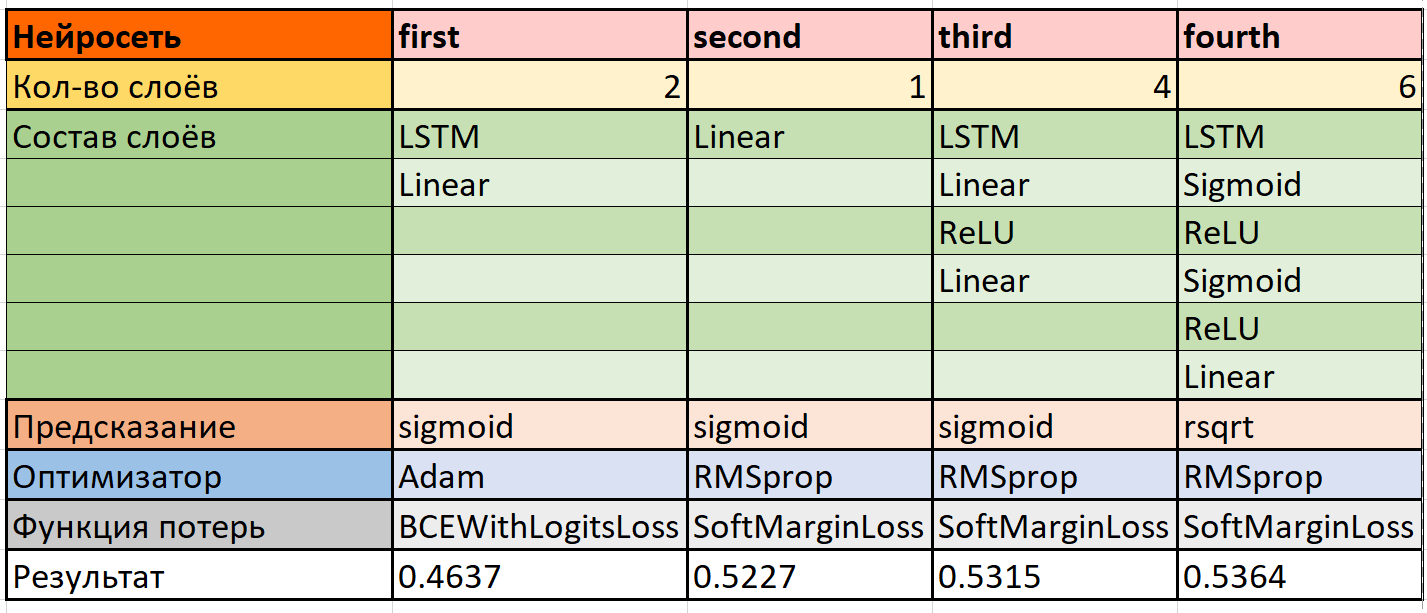

In [892]:
from IPython.display import Image, display

display(Image('result.png', width=800))